<img src=https://www.universidadviu.com/sites/universidadviu.com/themes/custom/universidadviu_com/logo.webp style="height: 100px">
<center style="color:#888">Master en Bigdata y  Data Science<br/>Trabajo Final de Master 2022</center>

## **Identificación de oportunidades de compra en el mercado inmobiliario para alquiler**

**Autor:** Luis Eduardo Rodriguez<br/>
**Módulo:** Modelado/Entrenamiento y Validacio  Alquiler

### **Descripcion:**

En este libro se va a revisar si hay similitud de los dataset de alquiler y ventas  esto nos dara una idea que tan fiable  puede ser el modelo entrenado con el set alquiler,  para ello reducirmeos la dimencionalidad de ambos dataset traspuestos y evaluamos la correción,  tambien se aplicar modelo de claisficación y se compara las matrices de confusión  de cada uno de los datasets.


### **Librerias**

In [1]:
#Cargamos librerias con todo lo necesario.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from sklearn.metrics import explained_variance_score

### **Carga de Datos**

Se carga la data colectada con Api idealista

In [2]:
#Lectura CSVs  desde directorio data desde donde esta guardado el libro, todos tiene las mismas columnas
df = pd.DataFrame()
for csv_file in Path('.').glob('data/*.csv'):
    df_aux = pd.read_csv(csv_file, index_col=None, header=0)
    df = df.append(df_aux, ignore_index=True, sort=False)
#df inicial
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9391 entries, 0 to 9390
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              9391 non-null   int64  
 1   propertyCode            9391 non-null   int64  
 2   thumbnail               9328 non-null   object 
 3   externalReference       7401 non-null   object 
 4   numPhotos               9391 non-null   int64  
 5   floor                   8427 non-null   object 
 6   price                   9391 non-null   float64
 7   propertyType            9391 non-null   object 
 8   operation               9391 non-null   object 
 9   size                    9391 non-null   float64
 10  exterior                9391 non-null   bool   
 11  rooms                   9391 non-null   int64  
 12  bathrooms               9391 non-null   int64  
 13  address                 9391 non-null   object 
 14  province                9391 non-null   

### **Limpieza de Datos**

Se aplica todos los cambios  del analisis exploratorio

In [3]:
#Eliminación de features innecesarias
dropcolumns = ['Unnamed: 0', 'thumbnail', 'externalReference', 'numPhotos', 'country',
               'hasVideo', 'newDevelopment','suggestedTexts', 'hasPlan', 'has3DTour',
               'has360', 'hasStaging', 'topNewDevelopment', 'labels', 'newDevelopmentFinished',
              'showAddress', 'priceByArea']
df = df.drop(columns=dropcolumns)

#Eliminación de duplicados
df = df.drop_duplicates(subset="url", keep='first')

#transformación de floors a números enteros y redondeamos a 1 decimal
df['floor'] = df['floor'].replace({'en': 0.5, 'bj': 0, 'ss': -0.5, 'st': -1}).astype(float)
df['floor'] = df['floor'].fillna(df['floor'].mean())
df['floor'] = df['floor'].round(decimals = 1)

#variables campos vacios con false.
df['hasLift'] = df['hasLift'].fillna(False)

#remplazamos Nulos por "{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}"
df['parkingSpace'] = df['parkingSpace'].fillna("{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}")

#Convertimos  Parking Space en: hasParkingSpace, isParkingSpaceIncludedInPrice, luego lo removemos
df_aux = df['parkingSpace'].str.split(n=4, expand=True)
df_aux.columns =['h1', 'hasParkingSpace', 'h2', 'isParkingSpaceIncludedInPrice', 'h3']
df_aux['hasParkingSpace'] = df_aux['hasParkingSpace'].replace({'False,': 'False', 'True,': 'True'})
df_aux['isParkingSpaceIncludedInPrice'] = df_aux['isParkingSpaceIncludedInPrice'].replace({'False}': 'False', 'False,': 'False', 'True}': 'True'})
df = pd.concat([df,df_aux[['hasParkingSpace', 'isParkingSpaceIncludedInPrice']]], axis=1).drop(['parkingSpace','isParkingSpaceIncludedInPrice'], axis=1)

# Sustituimos NAN en status por "good"
df['status'] = df['status'].fillna("good")

# Sustituimos NAN en distrito por municipalidades. y en vecindario por distrito
df['district'] = df['district'].fillna(df['municipality'])
df['neighborhood'] = df['neighborhood'].fillna(df['district'])

#Convertimos  detailType en los subgrupos Typology y Subtypology, remplazamos nan  de SubTypology por Typology
df_aux = df['detailedType'].str.split(n=3, expand=True)
df_aux.columns =['h1', 'typology', 'h2', 'subTypology']
df_aux['typology'] = df_aux['typology'].replace({"'chalet',": 'chalet', "'chalet'}": 'chalet',
                                                 "'flat',": 'flat', "'flat'}": 'flat',
                                                 "'countryHouse',": 'countryHouse', "'countryHouse'}": 'countryHouse'})
df_aux['subTypology'] = df_aux['subTypology'].replace({"'casaTerrera'}": 'casaTerrera', "'casale'}": 'casale',
                                                       "'countryHouse'}": 'countryHouse', "'duplex'}": 'duplex',
                                                       "'independantHouse'}": 'independantHouse', "'studio'}": 'studio',
                                                      "'terracedHouse'}": 'terracedHouse', "'penthouse'}": 'penthouse',
                                                      "'semidetachedHouse'}": 'semidetachedHouse'})
df_aux['subTypology'] = df_aux['subTypology'].fillna(df_aux['typology'])

df = pd.concat([df,df_aux[['typology', 'subTypology']]], axis=1).drop(['detailedType','typology'], axis=1)

#Transformamos en variables numéricas  todas  las tipo binario (True or False)
columns = df.loc[: , (df == 'False').any()].columns
for column in columns:
    df[column] = df[column].map({'True': True, 'False': False})
columns = df.select_dtypes('bool').columns
for column in columns:
    df[column] = df[column].astype(float)

#Filtrado de Muestras de barcelona  distance < 5000
df = df[((df['province']=="Barcelona") & (df['distance']<5000)) | (df['province']=="Madrid")]

#Insersion de variable logprice
df['Logprice'] = np.log(df.price.values)

#Quitamos Outlier, para viviendas en venta y alquiler valores obtenidos del analisis exploratorio:
cleaned_df = df[((df['operation']=="rent") & (df['price']<4730)) | (df['operation']=="sale")]
cleaned_df = cleaned_df[((cleaned_df['operation']=="sale") & (cleaned_df['price']<1691000)) | (cleaned_df['operation']=="rent")]

#Quitamos Outlier en el tamaño, en este caso pisos mayores a 296m2
cleaned_df = cleaned_df[cleaned_df['size'] < 296]
#Quitamos Outliers, que vemos que son pisos con más de 9 cuartos
cleaned_df = cleaned_df[cleaned_df['rooms'] <= 9]
#Quitamos Outliers, que vemos que son pisos con más de 5 baños
cleaned_df = cleaned_df[cleaned_df['bathrooms'] <= 5]
#Quitamos Outliers, que vemos que son pisos con más de 13 pisos
cleaned_df = cleaned_df[cleaned_df['floor'] <= 13]

#df  final despues de la limpieza
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 9389
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   propertyCode     7620 non-null   int64  
 1   floor            7620 non-null   float64
 2   price            7620 non-null   float64
 3   propertyType     7620 non-null   object 
 4   operation        7620 non-null   object 
 5   size             7620 non-null   float64
 6   exterior         7620 non-null   float64
 7   rooms            7620 non-null   int64  
 8   bathrooms        7620 non-null   int64  
 9   address          7620 non-null   object 
 10  province         7620 non-null   object 
 11  municipality     7620 non-null   object 
 12  district         7620 non-null   object 
 13  neighborhood     7620 non-null   object 
 14  latitude         7620 non-null   float64
 15  longitude        7620 non-null   float64
 16  url              7620 non-null   object 
 17  distance      

In [4]:
cleaned_df.columns

Index(['propertyCode', 'floor', 'price', 'propertyType', 'operation', 'size',
       'exterior', 'rooms', 'bathrooms', 'address', 'province', 'municipality',
       'district', 'neighborhood', 'latitude', 'longitude', 'url', 'distance',
       'description', 'status', 'hasLift', 'hasParkingSpace', 'subTypology',
       'Logprice'],
      dtype='object')

### Datos Sinteticos
Creamos una variable ProvMunDist concat(Province-Municipality-Distric)   para evitar duplicidades
Calculamos el precio medio del distrito, luego decidimos cual usar

In [5]:
#Creación de Variables sintéticas para agrupar Province|Municipality|District|Neighbourhood ya que muchos de las categorias mas bajas se repiten

cleaned_df['pmdistrict'] = cleaned_df['province'] + '|' + cleaned_df['municipality'] + '|' +  cleaned_df['district']
cleaned_df['pmdneigh'] = cleaned_df['province'] + '|' + cleaned_df['municipality'] + '|' +  cleaned_df['district'] + '|' +  cleaned_df['neighborhood']


In [6]:
# Seleccionamos features con las que se va a trabajar en el modelado
features=['operation', 'floor', 'price', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 
          'hasLift', 'hasParkingSpace', 'propertyType', 'pmdistrict']
validated_df = cleaned_df[features]
#sale_df_regresion = df_rent.copy()

In [7]:
print('all',validated_df.shape)
validated_df.info()

all (7620, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 9389
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   operation        7620 non-null   object 
 1   floor            7620 non-null   float64
 2   price            7620 non-null   float64
 3   size             7620 non-null   float64
 4   exterior         7620 non-null   float64
 5   rooms            7620 non-null   int64  
 6   bathrooms        7620 non-null   int64  
 7   distance         7620 non-null   int64  
 8   hasLift          7620 non-null   float64
 9   hasParkingSpace  7620 non-null   float64
 10  propertyType     7620 non-null   object 
 11  pmdistrict       7620 non-null   object 
dtypes: float64(6), int64(3), object(3)
memory usage: 773.9+ KB


### Data Preparation

Probamos con la conversion de cat a numericas considerando como es la precicions de acuerdo al analisis  de Laureae 2017
https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931

<img src=https://miro.medium.com/max/1296/1*uQoAMGOayWbsXpE78p-6uA.png style="height: 600px">


* Categorical features with large cardinalities (over 1000): Binary
* Categorical features with small cardinalities (less than 1000): Numeric

In [8]:
# Revisamos la cardinalidad
print('pmdistict cardinalities: ',validated_df.groupby(['pmdistrict']).size().count())
print('propertyType Cardinality: ',validated_df.groupby(['propertyType']).size().count())

pmdistict cardinalities:  154
propertyType Cardinality:  6


In [9]:
#Convertimos estas variables a dummies 
validated_df = pd.get_dummies(validated_df, columns=['pmdistrict'])
validated_df = pd.get_dummies(validated_df, columns=['propertyType'])

In [10]:
#convertimos todos estos campos a ENTEROS y rellenamos con False los nulos.

validated_df['bathrooms'] = validated_df['bathrooms'].astype(float)
validated_df['rooms'] = validated_df['rooms'].astype(float)
validated_df['distance'] = validated_df['distance'].astype(float)

In [11]:
#Revisamos el DF preparado

validated_df.info(verbose=True, show_counts=True)
validated_df.columns
validated_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 9389
Data columns (total 170 columns):
 #    Column                                                                     Non-Null Count  Dtype  
---   ------                                                                     --------------  -----  
 0    operation                                                                  7620 non-null   object 
 1    floor                                                                      7620 non-null   float64
 2    price                                                                      7620 non-null   float64
 3    size                                                                       7620 non-null   float64
 4    exterior                                                                   7620 non-null   float64
 5    rooms                                                                      7620 non-null   float64
 6    bathrooms                                     

,operation,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace,...,pmdistrict_Madrid|Velilla de San Antonio|Velilla de San Antonio,pmdistrict_Madrid|Villaviciosa de Odón|Castillo - Campodón,pmdistrict_Madrid|Villaviciosa de Odón|Centro,pmdistrict_Madrid|Villaviciosa de Odón|El Bosque,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio
0,rent,5.0,800.0,45.0,1.0,1.0,1.0,1267.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,rent,1.0,3200.0,210.0,1.0,3.0,3.0,601.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,rent,2.0,1500.0,97.0,0.0,2.0,2.0,2518.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,rent,5.0,3100.0,220.0,1.0,2.0,3.0,876.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,rent,3.0,2100.0,169.0,1.0,3.0,2.0,667.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0


### **Separamos Datos de Ventas y Alquiler**

In [12]:
#separamos el dataset por los dos tipos de operación y borramos y la variable objetivo price

df_rent = validated_df[validated_df['operation']== 'rent']
df_rent = df_rent.drop(['operation', 'price'], axis=1)

df_sale = validated_df[validated_df['operation']== 'sale']
df_sale = df_sale.drop(['operation', 'price'], axis=1)

In [13]:
print(df_rent.shape)
print(df_sale.shape)

(4236, 168)
(3384, 168)


### Trasponermos Datasets y scalamos

In [14]:
from numpy import corrcoef, transpose, arange

df_sale_trans = transpose(df_sale)
df_rent_trans = transpose(df_rent)
print(df_sale_trans.shape)
print(df_rent_trans.shape)

(168, 3384)
(168, 4236)


In [15]:
#Usamos RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#rs=RobustScaler() #lo probamos pero la variacion es mucho mayor  nos quedamos con standardScaler
rs=StandardScaler()

sale_df_robust = rs.fit_transform(df_sale_trans)
rent_df_robust = rs.fit_transform(df_rent_trans) #No se puede usar el mismo escaler al no tener la misma dimension
names = df_rent.columns #obtener la lista de features
print(sale_df_robust.shape)
print(rent_df_robust.shape)
names

(168, 3384)
(168, 4236)


Index(['floor', 'size', 'exterior', 'rooms', 'bathrooms', 'distance',
       'hasLift', 'hasParkingSpace',
       'pmdistrict_Barcelona|Barcelona|Ciutat Vella',
       'pmdistrict_Barcelona|Barcelona|Eixample',
       ...
       'pmdistrict_Madrid|Velilla de San Antonio|Velilla de San Antonio',
       'pmdistrict_Madrid|Villaviciosa de Odón|Castillo - Campodón',
       'pmdistrict_Madrid|Villaviciosa de Odón|Centro',
       'pmdistrict_Madrid|Villaviciosa de Odón|El Bosque',
       'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio'],
      dtype='object', length=168)

### Aplicamos PCA

In [16]:
# Aplicando PCA
from sklearn.decomposition import PCA
estimator1 = PCA (n_components = 1)
estimator2 = PCA (n_components = 1)
X_pca = estimator1.fit_transform(sale_df_robust)
Y_pca = estimator2.fit_transform(rent_df_robust)
print("Variance Ratio PCA_sale: ", estimator1.explained_variance_ratio_)
print("Variance Ratio PCA_rent: ", estimator2.explained_variance_ratio_)



Variance Ratio PCA_sale:  [0.99574684]
Variance Ratio PCA_rent:  [0.9956946]


In [17]:
sale_PCA = pd.DataFrame(X_pca, index=names, columns=['sale'])
rent_PCA = pd.DataFrame(Y_pca, index=names, columns=['rent'])
df_PCA = sale_PCA.copy()
df_PCA = df_PCA.join(rent_PCA)
print(df_PCA.shape)
df_PCA.head()

(168, 2)


,sale,rent
floor,-3.884382,-3.994661
size,24.303283,31.412909
exterior,-4.450568,-4.930954
rooms,-3.899856,-4.375270
bathrooms,-4.172059,-4.618043


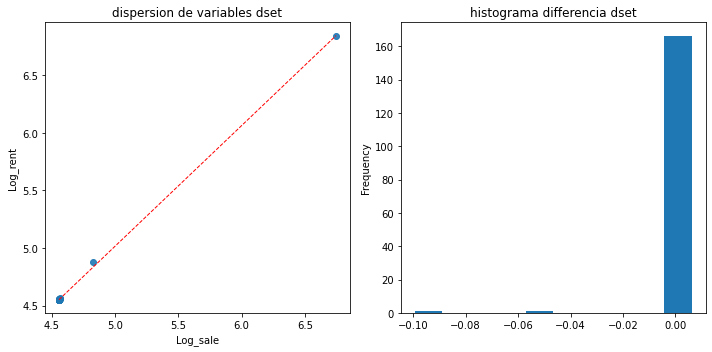

correlation entre datasets de ventas vs Alquiler:  0.9999872075451516


In [18]:
df_PCA['Log_rent'] = np.log(df_PCA.rent.values+100) #10000 con robustscaler, 100 con standarsccaler
df_PCA['Log_sale'] = np.log(df_PCA.sale.values+100)
df_PCA['Log_diff'] = df_PCA['Log_sale']-df_PCA['Log_rent']
df_PCA['diff'] = df_PCA['sale']-df_PCA['rent']
fig, axs = plt.subplots(1,2, figsize=(10, 5))
#sns.scatterplot(data=df_PCA,x='Log_sale',y='Log_rent',ax=axs[0]).set_title('dispersion de variables dset')
axs[0].scatter(df_PCA.Log_sale.values,df_PCA.Log_rent.values, alpha=0.9)
axs[0].plot([df_PCA.Log_sale.values.min(), df_PCA.Log_sale.values.max()], [df_PCA.Log_rent.min(), df_PCA.Log_rent.max()], "--r", linewidth=1)
axs[0].set_xlabel("Log_sale")
axs[0].set_ylabel("Log_rent")
axs[0].title.set_text("dispersion de variables dset")
#axs[1] = df_PCA['diff'].plot(kind='hist',x='diff', xlabel='diff' ,title='histograma differencia dset')
axs[1] = df_PCA['Log_diff'].plot(kind='hist',x='Log_diff', xlabel='Log_diff',title='histograma differencia dset')
fig.tight_layout()
plt.show()
#correlation = df_PCA.corr()
correlation = df_PCA['sale'].corr(df_PCA['rent'])
print('correlation entre datasets de ventas vs Alquiler: ',correlation)

In [19]:
#pd.set_option('max_columns', None)
df_PCA.head(10)

,sale,rent,Log_rent,Log_sale,Log_diff,diff
floor,-3.884382,-3.994661,4.564404,4.565552,0.001148,0.110279
size,24.303283,31.412909,4.878344,4.822724,-0.055620,-7.109626
exterior,-4.450568,-4.930954,4.554603,4.559644,0.005040,0.480386
rooms,-3.899856,-4.375270,4.560431,4.565391,0.004959,0.475413
bathrooms,-4.172059,-4.618043,4.557889,4.562554,0.004665,0.445985
distance,749.595755,838.472274,6.844253,6.744761,-0.099493,-88.876519
hasLift,-4.465556,-4.919955,4.554719,4.559487,0.004768,0.454399
hasParkingSpace,-4.650721,-5.206446,4.551701,4.557547,0.005845,0.555725
pmdistrict_Barcelona|Barcelona|Ciutat Vella,-4.625278,-5.197883,4.551792,4.557814,0.006022,0.572605
pmdistrict_Barcelona|Barcelona|Eixample,-4.634453,-5.175575,4.552027,4.557717,0.005690,0.541122


### Vefirificacion por Clusterizacion

Opcionalmente revisamos la similitud de los dos datasets mediante clusterizacion de los dataset y vemos que tan similares la variable objetivo

In [20]:
#Insersion de variable logprice
validated_df['Logprice'] = np.log(validated_df.price.values)

#separamos el dataset por los dos tipos de operación y borramos y la variable objetivo price

df_rent = validated_df[validated_df['operation']== 'rent']
df_sale = validated_df[validated_df['operation']== 'sale']

#Convertimos la variable Price en tramos para clasificación: Escogemos 10 tramnos de precios unformes
df_sale_ = df_sale.copy()
df_rent_ = df_rent.copy()
abc = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
df_sale_['price_range'] = pd.qcut(df_sale['Logprice'], 10, labels=[abc[i] for i in range(0, 10)])
df_rent_['price_range'] = pd.qcut(df_rent['Logprice'], 10, labels=[abc[i] for i in range(0, 10)])
df_sale = df_sale_.copy()
df_rent = df_rent_.copy()

#Eliminamos variables
df_rent = df_rent.drop(['operation', 'price','Logprice'], axis=1)
df_sale = df_sale.drop(['operation', 'price','Logprice'], axis=1)


print(df_rent.shape)
print(df_sale.shape)

(4236, 169)
(3384, 169)


In [21]:
df_sale.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3384 entries, 4441 to 9389
Data columns (total 169 columns):
 #    Column                                                                     Non-Null Count  Dtype   
---   ------                                                                     --------------  -----   
 0    floor                                                                      3384 non-null   float64 
 1    size                                                                       3384 non-null   float64 
 2    exterior                                                                   3384 non-null   float64 
 3    rooms                                                                      3384 non-null   float64 
 4    bathrooms                                                                  3384 non-null   float64 
 5    distance                                                                   3384 non-null   float64 
 6    hasLift                            

In [22]:
df_sale.groupby(['price_range']).size()

price_range
A    349
B    328
C    349
D    337
E    349
F    319
G    363
H    315
I    336
J    339
dtype: int64

### Prueba1: Por similitud en el calculo de cluster por rango eps

In [23]:
#features a evaluar, X
df_rent_X = df_rent.drop(['price_range'], axis=1)
df_sale_X = df_sale.drop(['price_range'], axis=1)
#features target Y del clasificado Price range
df_rent_Y = df_rent[['price_range']]
df_sale_Y = df_sale[['price_range']]

#Usamos RobustScaler para normalizar los datos
from sklearn.preprocessing import RobustScaler
rent_df_anomalias_norm = RobustScaler().fit_transform(df_rent_X)
sale_df_anomalias_norm = RobustScaler().fit_transform(df_sale_X)

In [24]:
#Evaluamos el epsilon que mejor se ajusta a los datos de Sales, con distancia minPts= ln(samples) para este grupo seria ln(3384)=8.12
from sklearn.cluster import DBSCAN
minPts=8
for eps in np.arange(1, 3.5, 0.20):
  dbs = DBSCAN(eps, min_samples=minPts).fit(sale_df_anomalias_norm)
  core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
  core_samples_mask[dbs.core_sample_indices_] = True
  labels = dbs.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

  1.00, 47, 2664
  1.20, 31, 1514
  1.40, 33, 1343
  1.60, 5, 439
  1.80, 4, 220
  2.00, 2, 105
  2.20, 1, 37
  2.40, 1, 12
  2.60, 1, 7
  2.80, 1, 0
  3.00, 1, 0
  3.20, 1, 0
  3.40, 1, 0


In [25]:
#Evaluamos el epsilon que mejor se ajusta a los datos de rent, con distancia minPts= ln(samples) para este grupo seria ln(4236)=8.35
from sklearn.cluster import DBSCAN
minPts=8
for eps in np.arange(1, 3.5, 0.20):
  dbs = DBSCAN(eps, min_samples=minPts).fit(rent_df_anomalias_norm)
  core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
  core_samples_mask[dbs.core_sample_indices_] = True
  labels = dbs.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

  1.00, 102, 1785
  1.20, 43, 1012
  1.40, 46, 801
  1.60, 1, 216
  1.80, 1, 106
  2.00, 2, 52
  2.20, 1, 12
  2.40, 1, 1
  2.60, 1, 1
  2.80, 1, 0
  3.00, 1, 0
  3.20, 1, 0
  3.40, 1, 0


Como se puede ver en la revision de clusters por rango de eps y outliers  los resultados no son similares, lo cual es contradictorio a los resultados cuando no se incluyeron las variables categoricas (district, propertyType)  ya en el analysis exploratorio se ve que la distribución por area geografica los datos no esta uniformemente distribuidos

###  Prueba 2:  por correlación  de la matris de confucion usando un NN Classifier

In [26]:
from sklearn.model_selection import train_test_split
#features a evaluar, X
df_rent_X = df_rent.drop(['price_range'], axis=1)
df_sale_X = df_sale.drop(['price_range'], axis=1)
#features target Y del clasificado Price range
df_rent_Y = np.array(df_rent[['price_range']])
df_sale_Y = np.array(df_sale[['price_range']])

#Usamos RobustScaler para normalizar los datos
from sklearn.preprocessing import RobustScaler
rent_df_anomalias_norm = RobustScaler().fit_transform(df_rent_X)
sale_df_anomalias_norm = RobustScaler().fit_transform(df_sale_X)

#Generamos los datos de Entrenamiento y Test, al 70 - 30
Xr_train, Xr_test, yr_train, yr_test = train_test_split(rent_df_anomalias_norm, df_rent_Y, test_size=.3, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(sale_df_anomalias_norm, df_sale_Y, test_size=.3, random_state=42)

print('rent_train: ',len(Xr_train),' rent_test: ',len(Xr_test))
print('sale_train: ',len(Xs_train),' rent_test: ',len(Xs_test))

rent_train:  2965  rent_test:  1271
sale_train:  2368  rent_test:  1016


### Preparamos el Entorno

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC


In [28]:
#Modelos
nnr = MLPClassifier(activation='relu', solver='adam', max_iter=1000, random_state=42, alpha=0.1)
nns = MLPClassifier(activation='relu', solver='adam', max_iter=1000, random_state=42, alpha=0.1)


In [29]:
#entrenamiento  set the rent
nnr.fit(Xr_train, yr_train.ravel())


MLPClassifier(alpha=0.1, max_iter=1000, random_state=42)

In [30]:
#entrenamiento set the sale
nns.fit(Xs_train, ys_train.ravel())

MLPClassifier(alpha=0.1, max_iter=1000, random_state=42)

In [31]:
nnr.get_params()

{'activation': 'relu',
 'alpha': 0.1,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Resultados set de prueba:
Mean_Score_rent:  0.36034618410700237
Mean_Score_sale: 0.4734251968503937
ARI_rent: 0.14911507660053103
ARI_sale: 0.23931386620450332
CorrCoef 0.9275325081668099


Text(0.5, 1.0, 'Matriz de Confusión Ventas')

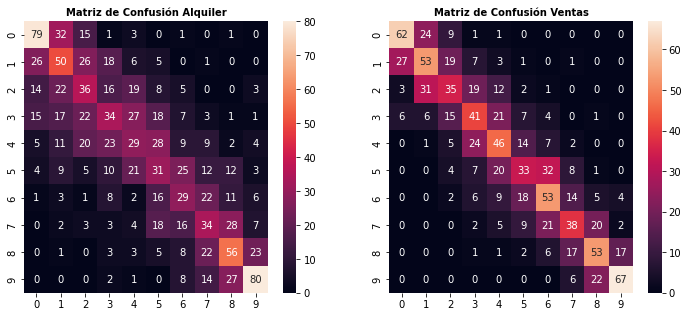

In [32]:
#Prediccion
yr_pred = nnr.predict(Xr_test)
ys_pred = nns.predict(Xs_test)
print('Resultados set de prueba:')
print('Mean_Score_rent: ',nnr.score(Xr_test, yr_test))
print('Mean_Score_sale:',nns.score(Xs_test, ys_test))
print('ARI_rent:',adjusted_rand_score(yr_test.ravel(), yr_pred.ravel()))
print('ARI_sale:',adjusted_rand_score(ys_test.ravel(), ys_pred.ravel()))

# Calculamos la matriz de confusion de cada set
from sklearn.metrics import confusion_matrix
rent_confm=confusion_matrix(yr_test, yr_pred)
sale_confm=confusion_matrix(ys_test, ys_pred)

#funcion para calcular coeficiente de correlacion entren las matrices
def correlation_coefficient(T1, T2):
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result

print('CorrCoef',correlation_coefficient(rent_confm, sale_confm))

fig, axs = plt.subplots(1,2, figsize=(12, 5))
sns.heatmap(rent_confm, ax=axs[0],annot=True).set_title('Matriz de Confusión Alquiler', fontsize=10, weight='bold')
sns.heatmap(sale_confm, ax=axs[1],annot=True).set_title('Matriz de Confusión Ventas', fontsize=10, weight='bold')

Resultados set de entrenamiento:
Mean_Score_rent:  0.6839797639123103
Mean_Score_sale: 0.8513513513513513
ARI_rent: 0.43391416087791757
ARI_sale: 0.7047902230756171
CorrCoef 0.9832069842492671


Text(0.5, 1.0, 'Matriz de Confusión Ventas')

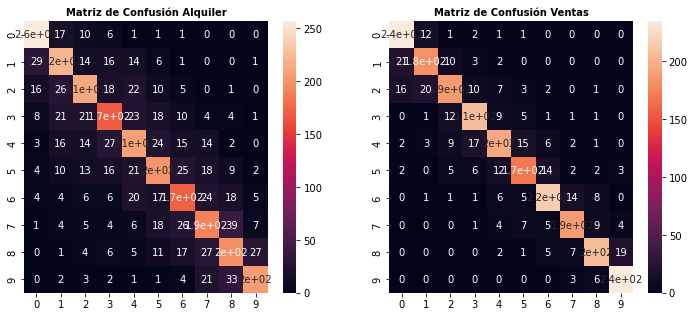

In [33]:
#Prediccion
yr_pred = nnr.predict(Xr_train)
ys_pred = nns.predict(Xs_train)
print('Resultados set de entrenamiento:')
print('Mean_Score_rent: ',nnr.score(Xr_train, yr_train))
print('Mean_Score_sale:',nns.score(Xs_train, ys_train))
print('ARI_rent:',adjusted_rand_score(yr_train.ravel(), yr_pred.ravel()))
print('ARI_sale:',adjusted_rand_score(ys_train.ravel(), ys_pred.ravel()))

# Calculamos la matriz de confusion de cada set
from sklearn.metrics import confusion_matrix
rent_confm=confusion_matrix(yr_train, yr_pred)
sale_confm=confusion_matrix(ys_train, ys_pred)

#funcion para calcular coeficiente de correlacion entren las matrices
def correlation_coefficient(T1, T2):
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result

print('CorrCoef',correlation_coefficient(rent_confm, sale_confm))

fig, axs = plt.subplots(1,2, figsize=(12, 5))
sns.heatmap(rent_confm, ax=axs[0],annot=True).set_title('Matriz de Confusión Alquiler', fontsize=10, weight='bold')
sns.heatmap(sale_confm, ax=axs[1],annot=True).set_title('Matriz de Confusión Ventas', fontsize=10, weight='bold')

Conclusion:  Comparando la correlacion de la matriz de confucion de valores predecidos tanto para los set de prueba y entrenamiento  es superior al 90%  lo cual nos da indicacion que hay bastante similitud y apezar que los etiquetas objetivos tenian diferente dimencion (rango de precios y alquiler)  los resultados son bastante buenos.